In [1]:
%load_ext autoreload
%autoreload 2

import mkl
mkl.set_num_threads(1)

48

# Preparations

In [2]:
# need to run if there are updates to resolution, binning, or mephistograms
%run ../../core/resolution.py
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from collections import namedtuple
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
import mephisto
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2
import settings as st
from tools import array_source_interp
from tqdm import tqdm


# Settings

In [5]:
e_res_files = {
    "baseline": join(st.LOCALPATH, "energy_smearing_GP_up.pckl"),
    "1:1": join(st.LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(st.LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"),
    "improved-50": join(st.LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"),
}


In [6]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# helper functions

In [7]:
# interpolation function to find the discovery threshold using a pandas.DataFrame input
def get_scaler(x, thresh):
    return np.power(
        10,
        np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
            np.log10(-np.log10(thresh))
        ),
    )


In [8]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    """ Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Detector configuration

## Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [10]:
with open(join(st.LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

## Atmospheric background

In [12]:
with open(join(st.LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


## Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [13]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


## Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [15]:
# angular resolution
with open(join(st.LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [16]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
flux_collection = {"powerlaw": PL_flux}

In [17]:
new_livetime = 3186 * 24 * 3600  # new ngc paper
old_livetime = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600 # old 10yr PS paper
old_ngc_events = 50.4 # phi 3E-14
new_ngc_events = 79 # phi 5E-14

old_txs_events = 12.3
old_txs_gamma = 2.1
#old_txs_flux = PL_flux()

In [19]:
new_ngc_flux = PL_flux(st.PHI_NGC, st.GAMMA_NGC, st.E0_NGC, "powerlaw")
uncorrected_ngc_flux = PL_flux(st.PHI_NGC*1.07, st.GAMMA_NGC, st.E0_NGC, "powerlaw")
old_ngc_flux = PL_flux(3E-14, st.GAMMA_NGC, st.E0_NGC, "powerlaw")


In [21]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad


# Set up LLH function

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux


In [22]:
from tools import poisson_llh

In [29]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        10**aeff_factor_s.bin_mids[1],
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


# Cross checks

## Old analysis

* E_res: baseline
* livetime: match number of events at horizon

### Check event numbers

In [30]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()

# old paper
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], livetime=old_livetime, **ngc_src_config
)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=old_ngc_flux,
)
print("old ngc 1068:", np.sum(k_s), ", should be", old_ngc_events)
# accounting for the fact that not every data set has 86-str
old_updated_livetime = old_livetime / np.sum(k_s) * old_ngc_events
print(
    "old:",
    old_livetime / (24 * 3600),
    "old_updated:",
    old_updated_livetime / (24 * 3600),
    "ratio:",
    old_ngc_events / np.sum(k_s),
)



old ngc 1068: 59.34571864111433 , should be 50.4
old: 3576.1 old_updated: 3037.041999439771 ratio: 0.8492609265512071


In [31]:
ident = "IceCube"
decs = np.arange(0, 71, step=10)
# some reference flux, but we'll be scaling that anyway
gamma2_flux = PL_flux(1e-15, 2, st.E0_NGC, "powerlaw")
tmp = []
num = 25
thresholds = [st.sigma5]
eres = baseline_eres
name = "base"

for dec in tqdm(np.deg2rad(decs)):
    if ident == "IceCube" and dec <= np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], livetime=old_updated_livetime, dec=dec, **bg_config
    )
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d[ident], livetime=old_updated_livetime, dec=dec, **src_config
    )
    bckg_flux = array_source_interp(
        dec, bckg_histo["IceCube"], st.sindec_mids, axis=1
    )
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        bckg_flux,
        energy_resolution=eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        10**aeff_factor_signal.bin_mids[1],
        eres,
        1,
        gamma2_flux,  # powerlaw
    )
    # calculate an estimate for the flux scaling
    scaler = 1 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        k_s = astro_flux(
            aeff_factor_signal,
            10**aeff_factor_signal.bin_mids[1],
            eres,
            scaler,
            gamma2_flux,  # powerlaw
        )
        k_i = k_s + k_b

        dct = dict(
            shape="powerlaw",
            aeff_factor_b=aeff_factor_bckg,
            aeff_factor_s=aeff_factor_signal,
            k_i=k_i,
            e_0=gamma2_flux.E0,
            phi_0=gamma2_flux.norm,
            energy_resolution=eres,
            bckg_flux=bckg_flux,
        )

        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_single(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        tmp_dct = {
            "ident": ident,
            "eres": name,
            "dec": dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)

        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == ident)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "gamma2_disc_pot_old_comparison.pickle"))

 12%|█▎        | 1/8 [00:00<00:02,  2.97it/s]

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]


In [33]:
import seaborn as sns
plt = sns.mpl.pyplot

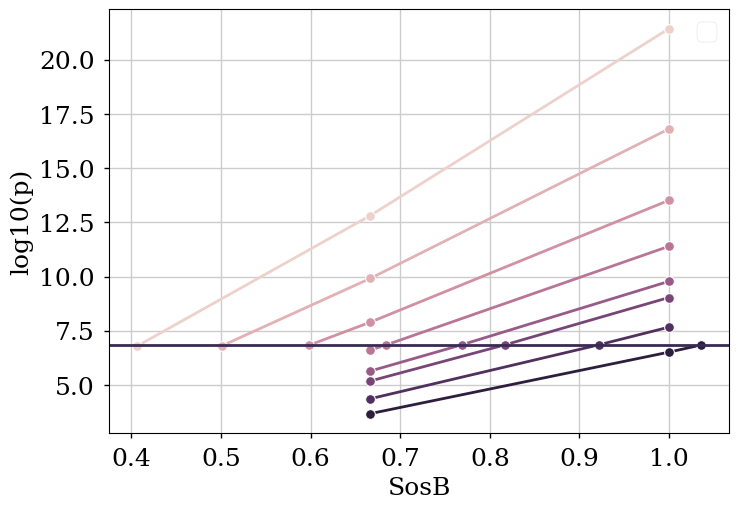

In [35]:
#df = pd.DataFrame(tmp)
ax = sns.lineplot(data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident")
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))

In [37]:
df = pd.read_pickle(join(st.LOCALPATH, "gamma2_disc_pot_old_comparison.pickle"))
flux = pd.DataFrame(
    df.groupby(["eres", "dec"]).apply(lambda x: get_scaler(x, st.sigma5))
    * gamma2_flux.norm,
    columns=["disc5"],
).reset_index()


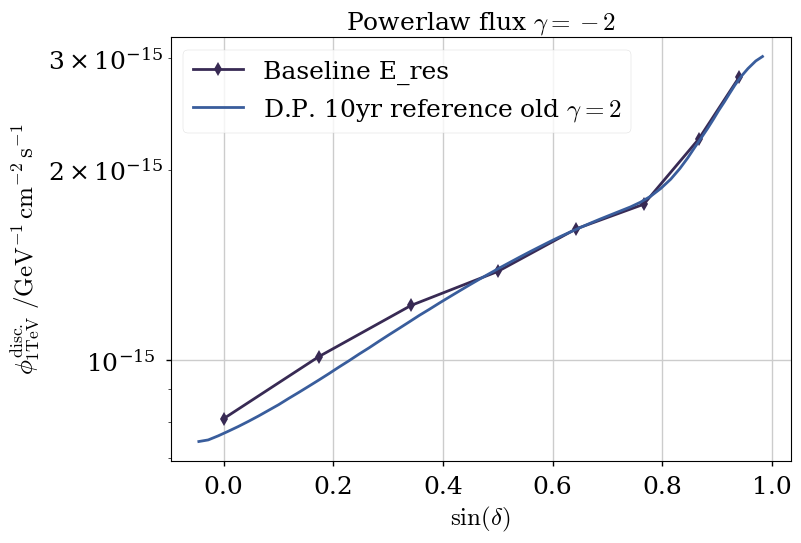

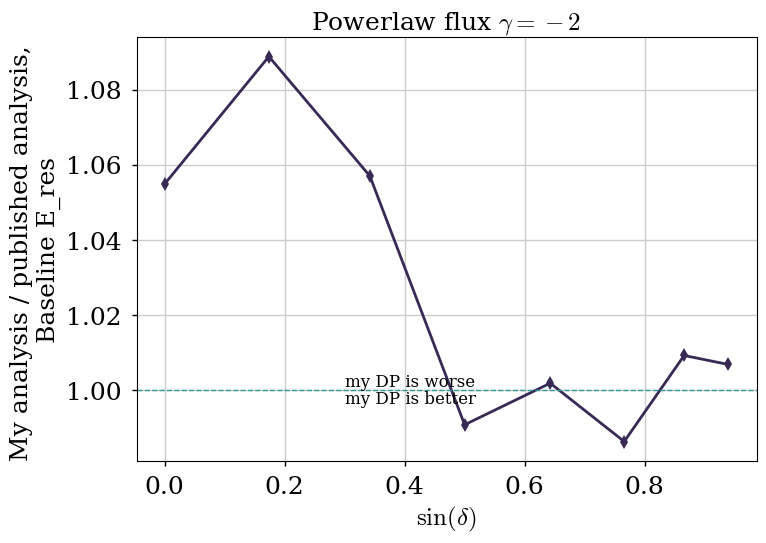

In [39]:
gamma = 2
ident = "IceCube"

# comparison to DP from old 10yr PS paper

ps_disc_old = np.genfromtxt(
    join(st.LOCALPATH, "ngc_DP_old_gamma-2.txt"), delimiter=","
)

ind_disc_old = np.argsort(ps_disc_old[:, 0])
xsd_old = ps_disc_old[:, 0][ind_disc_old]
ic_10yr_old = ps_disc_old[:, 1][ind_disc_old]
spl_10yr_old = splrep(xsd_old, ic_10yr_old)



f, ax = plt.subplots()
#for eres, series in flux.groupby(["eres"]):
lb_eres = "Baseline E_res"
plt.plot(
    np.sin(flux.dec),
    flux.disc5,
    label=lb_eres,
    **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
)

ax.plot(
    xsd_old, ic_10yr_old * 1e-15, label=rf"D.P. 10yr reference old $\gamma={gamma2_flux.gamma}$"
)

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
# ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.legend(loc=0)
ax.set_title(rf"Powerlaw flux $\gamma=-{gamma2_flux.gamma}$")
f.savefig(f"../../plots/gamma{gamma2_flux.gamma}_disc_pot_old.pdf", bbox_inches="tight")

f, ax = plt.subplots()
#for eres, series in flux.groupby(["eres"]):
plt.plot(
    np.sin(flux.dec),
    flux.disc5 / splev(np.sin(flux.dec), spl_10yr_old) * 1e15,
    **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
)
plt.axhline(1, ls="--", lw=1, color="#339999")
plt.text(0.3, 1.0, "my DP is better", va="top", fontsize=12)
plt.text(0.3, 1.0, "my DP is worse", va="bottom", fontsize=12)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    #r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    "My analysis / published analysis, \n" + lb_eres
)
ax.set_title(rf"Powerlaw flux $\gamma=-{gamma2_flux.gamma}$")
#ax.legend(loc=0)
f.savefig(f"../../plots/gamma{gamma2_flux.gamma}_disc_pot_ratio_old.pdf", bbox_inches="tight")


## New analysis

In [41]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()

# new paper
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], livetime=new_livetime, **ngc_src_config
)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=new_ngc_flux,
)

print("new ngc 1068:", np.sum(k_s))
print("should be:", new_ngc_events, "ratio:", new_ngc_events / np.sum(k_s))
new_updated_livetime = new_livetime * new_ngc_events / np.sum(k_s)

# cross check:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], livetime=new_updated_livetime, **ngc_src_config
)

print(
    "cross check:",
    np.sum(
        astro_flux(
            aeff_factor_signal,
            10**aeff_factor_signal.bin_mids[1],
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=new_ngc_flux,
        )
    ),
) # :)


new ngc 1068: 88.11995357633094
should be: 79 ratio: 0.8965052385277179
cross check: 79.0


In [43]:
ident = "IceCube"
decs = np.arange(0, 71, step=10)
# some reference flux, but we'll be scaling that anyway
gamma2_flux = PL_flux(1e-15, 2.0, st.E0_NGC, "powerlaw")
tmp = []
num = 25
thresholds = [st.sigma5]
eres = improved_eres
name = "improved"

for dec in tqdm(np.deg2rad(decs)):
    if ident == "IceCube" and dec <= np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], livetime=new_updated_livetime, dec=dec, **bg_config
    )
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d[ident], livetime=new_updated_livetime, dec=dec, **src_config
    )
    bckg_flux = array_source_interp(dec, bckg_histo["IceCube"], st.sindec_mids, axis=1)
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        bckg_flux,
        energy_resolution=eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        10**aeff_factor_signal.bin_mids[1],
        eres,
        1,
        gamma2_flux,  # powerlaw
    )
    # calculate an estimate for the flux scaling
    scaler = 1 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:

        k_s = astro_flux(
            aeff_factor_signal,
            10**aeff_factor_signal.bin_mids[1],
            eres,
            scaler,
            gamma2_flux,  # powerlaw
        )
        k_i = k_s + k_b

        dct = dict(
            shape="powerlaw",
            aeff_factor_b=aeff_factor_bckg,
            aeff_factor_s=aeff_factor_signal,
            k_i=k_i,
            e_0=gamma2_flux.E0,
            phi_0=gamma2_flux.norm,
            energy_resolution=eres,
            bckg_flux=bckg_flux,
        )

        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_single(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        tmp_dct = {
            "ident": ident,
            "eres": name,
            "dec": dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)

        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == ident)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "gamma2_disc_pot_new_comparison.pickle"))


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


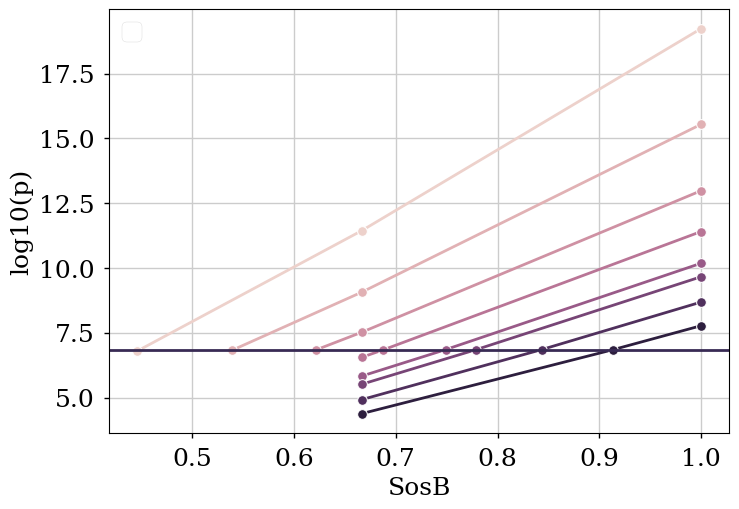

In [44]:
ax = sns.lineplot(data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident")
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))

In [46]:
df = pd.read_pickle(join(st.LOCALPATH, "gamma2_disc_pot_new_comparison.pickle"))
flux = pd.DataFrame(
    df.groupby(["eres", "dec"]).apply(lambda x: get_scaler(x, st.sigma5))
    * gamma2_flux.norm,
    columns=["disc5"],
).reset_index()


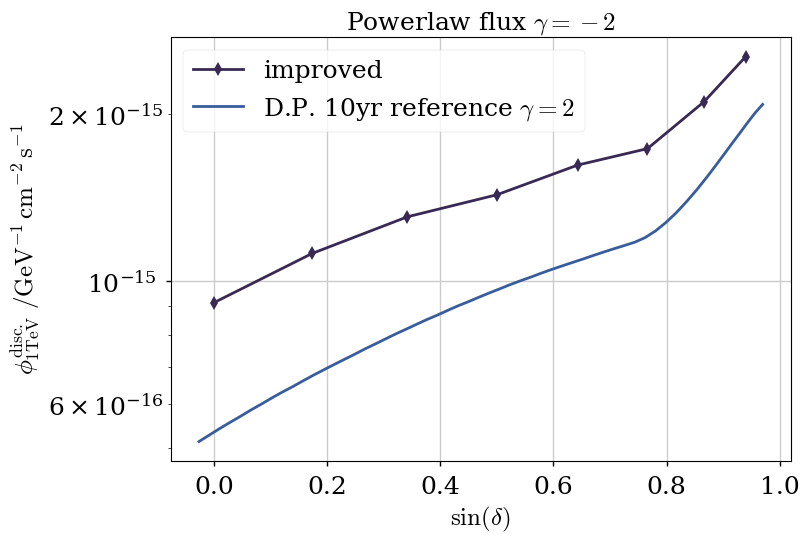

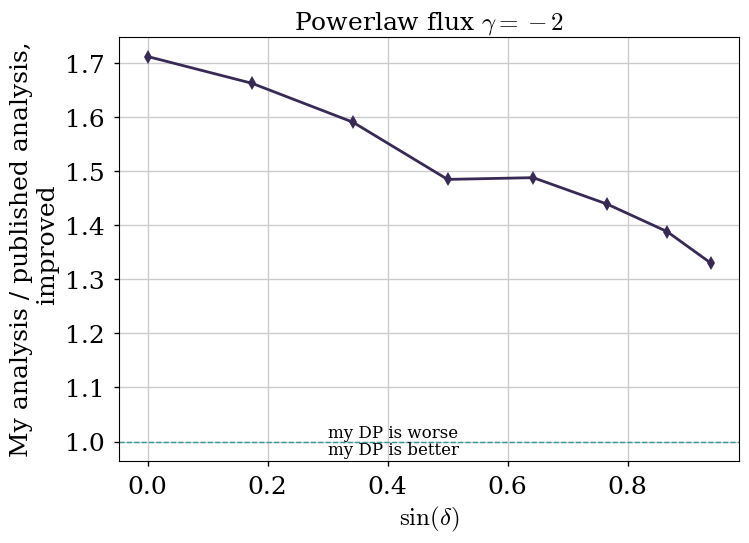

In [48]:
# comparison to DP from ngc paper

ps_disc = np.genfromtxt(
    join(st.LOCALPATH, "ngc_DP_gamma-2.txt"), delimiter=","
)

ind_disc = np.argsort(ps_disc[:, 0])
xsd = ps_disc[:, 0][ind_disc]
ic_10yr = ps_disc[:, 1][ind_disc]
spl_10yr = splrep(xsd, ic_10yr)

gamma = 2
ident = "IceCube"

f, ax = plt.subplots()
#for eres, series in flux.groupby(["eres"]):
plt.plot(
    np.sin(flux.dec),
    flux.disc5,
    label=name,
    **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
)

ax.plot(xsd, ic_10yr * 1e-15, label=rf"D.P. 10yr reference $\gamma={gamma}$")

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
# ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.legend(loc=0)
ax.set_title(rf"Powerlaw flux $\gamma=-{gamma}$")
f.savefig(f"../../plots/gamma{gamma}_disc_pot_new.pdf", bbox_inches="tight")

f, ax = plt.subplots()
#for eres, series in flux.groupby(["eres"]):
plt.plot(
    np.sin(flux.dec),
    flux.disc5 / splev(np.sin(flux.dec), spl_10yr) * 1e15,
    **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
)
plt.axhline(1, ls="--", lw=1, color="#339999")
plt.text(0.3, 1.0, "my DP is better", va="top", fontsize=12)
plt.text(0.3, 1.0, "my DP is worse", va="bottom", fontsize=12)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    #r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    "My analysis / published analysis,\n " + name
)
ax.set_title(rf"Powerlaw flux $\gamma=-{gamma}$")
#ax.legend(loc=0)
f.savefig(f"../../plots/gamma{gamma}_disc_pot_ratio_new.pdf", bbox_inches="tight")
